In [1]:
import torch
import torchvision

from pathlib import Path
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from plot import draw_apparatus
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

## Epoch testing code

The number of epochs required to train autoencoder models will be verified in this notebook. This requires a set dataset with a specific excluded validation set, and a specific model. Performance will be evaluated by training the model over 100 , 1000, 10000, and 20000 epochs to determine when overfitting happens (validation score >> train score). In addition, model performance also needs to be evaluated by examining the predicted profiles. 

In [2]:
# load datasets
root = Path.cwd().parent
data_dir = root/'data'/'image_datasets'
data_list = sorted(data_dir.rglob('*.npz'))

In [3]:
def plot_data(data):
    from plot import draw_apparatus
    fig, ax = plt.subplots(ncols=5, sharey=True)
    for i in range(5):
        ax[i].imshow(data[i, :, :], origin='lower', extent=[0, 20, 0, 70.7])
        draw_apparatus(ax[i])

    return fig

In [4]:
def get_dataset(V, P):
    """Function to load data from a pair of V, P

    This is surprisingly easier than using netCDFs lmao.

    Args:
        V (int or float): voltage
        P (int or float): pressure

    Returns:
        np.array: Array with shape (5, 707, 200)
    """
    V = str(float(V))
    P = str(float(P))
    file = next(data_dir.glob(f'{V}_{P}.npz'))
    array = np.load(file)['arr_0']

    return array

In [5]:
test = get_dataset(300, 80) 

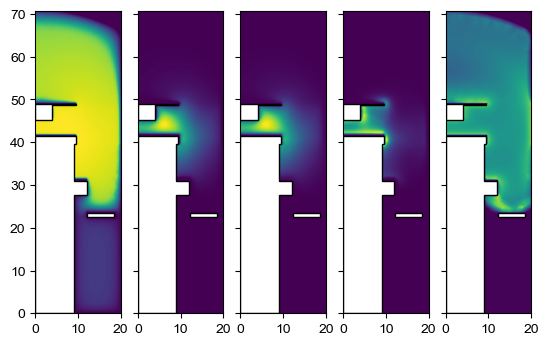

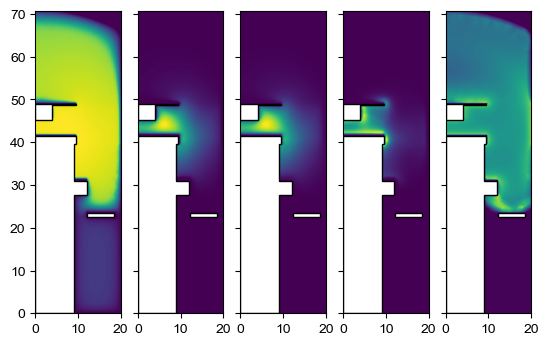

In [31]:
plot_data(test)

### To do:
* crop the images
* downscale images
* scale for each variable
* set up training loop function
* train, test, validation split
* plot train and validation error (I can probably just use the one in plot.py)
* plot images

In [7]:
test.shape

(5, 707, 200)

In [8]:
def crop(image, corner, width, height):
    # image shape = 5, 707, 200
    """Crop images to desired size (x and y). 

    Assumes input images with a shape of (channels, height, width).

    Args:
        image (np.ndarray): Image to be cropped.
        corner (Tuple[int, int]): Location of the lower-left corner for the cropping.
        width (Crop width): Width of the crop.
        height (Crop height): Height of the crop.

    Returns:
        np.ndarray: Cropped n-channel image.
    """    
    startx, starty = corner

    endx = startx + width
    endy = starty + height

    return image[:, starty:endy, startx:endx]


In [9]:
crop(test, (0, 350), 200, 200).shape

(5, 200, 200)

In [29]:
def plot_crop(data, cbar=None):
    fig = plt.figure()

    grid = ImageGrid(fig, 111,  # similar to fig.add_subplot(142).
                     nrows_ncols=(1, 5), axes_pad=0.0, label_mode="L", share_all=True,
                     cbar_location="right", cbar_mode=cbar, cbar_size="5%", cbar_pad='5%')

    for i, ax in enumerate(grid):
        im = ax.imshow(data[i, :, :], origin='lower', 
                       extent=[0, 20, 35, 55], cmap='magma')
        draw_apparatus(ax)

    grid.cbar_axes[0].colorbar(im)

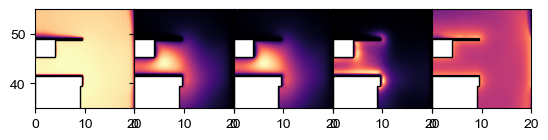

In [30]:
cropped = crop(test, (0, 350), 200, 200)
plot_crop(cropped)

In [12]:
def downscale(image_stack, resolution):
    import cv2
    data = np.stack([cv2.resize((np.moveaxis(image, 0, -1)), (32, 32)) for image in image_stack])
    return np.moveaxis(data, -1, 1)  # revert moveaxis operation

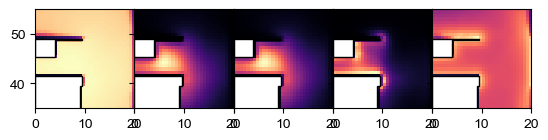

In [24]:
scaled = downscale(cropped, 64)
plot_crop(scaled)

In [14]:
nc_path = root/'data'/'interpolation_datasets'/'full_interpolation.nc'
ds = xr.open_dataset(nc_path)
ds

<xarray.Dataset>
Dimensions:        (y: 707, x: 200, P: 8, V: 4)
Coordinates:
  * y              (y) float64 0.0 0.001 0.002 0.003 ... 0.703 0.704 0.705 0.706
  * x              (x) float64 0.0 0.001 0.002 0.003 ... 0.196 0.197 0.198 0.199
  * P              (P) float64 5.0 10.0 30.0 45.0 60.0 80.0 100.0 120.0
  * V              (V) float64 200.0 300.0 400.0 500.0
Data variables:
    potential (V)  (V, P, y, x) float64 ...
    Ne (#/m^-3)    (V, P, y, x) float64 ...
    Ar+ (#/m^-3)   (V, P, y, x) float64 ...
    Nm (#/m^-3)    (V, P, y, x) float64 ...
    Te (eV)        (V, P, y, x) float64 ...

In [15]:
np.nan_to_num(ds['potential (V)'].values).min()

-1.2891021583527617e-14

In [16]:
for variable in list(ds.keys()):
    var_data = np.nan_to_num(ds[variable].values)
    print(var_data.min())
    print(var_data.max())
    print('\n')

-1.2891021583527617e-14
205.71708513606058


0.0
1.675699409702132e+16


0.0
1.6757694097021322e+16


0.0
8.549053831954201e+18


0.0
11.672450000000012




In [19]:
def minmax_scale(image):

    scaled_arrays = []

    for i, variable in enumerate(list(ds.keys())):

        var_data = np.nan_to_num(ds[variable].values)
        a = 0.0  # force 0 minimum
        b = var_data.max()

        data_array = image[i, :, :]

        # minmax scale
        scaled_arrays.append((data_array-a) / (b - a))

    scaled = np.stack(scaled_arrays)

    assert scaled.shape == image.shape

    return scaled


In [20]:
minmax = minmax_scale(cropped)

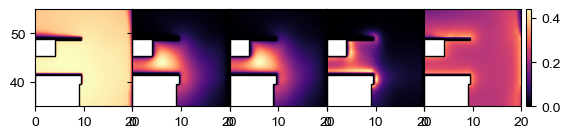

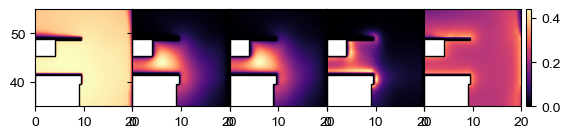

In [21]:
plot_crop(minmax, 'single')

In [ ]:
# load train validation sets
# crop, downscale
# minmax scale
# train model over 10000 epochs